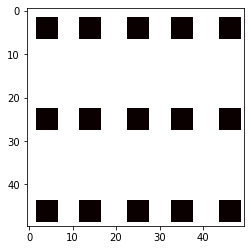

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import Tuple, Set, List
from enum import Enum
from itertools import permutations, combinations_with_replacement
import math

class RandomExclusionSet(object):
    def __init__(self, n_voids, size, depth, rows):
        self.n_voids = n_voids
        self.size = size
        self.depth = depth
        self.rows = rows
        self.cols = self.n_voids // self.rows
        
    def __len__(self):
        return self.n_voids * self.size
        
class IsotropicVoxelGrid(object):
    def __init__(
        self, 
        dataset_size: int, 
    ):
        self.grid = np.ones((dataset_size, dataset_size, dataset_size))
        
    def __call__(self, exclusions: RandomExclusionSet):           
            # Evenly subdivide along y-axis
            y_axis_origins = np.linspace(
                exclusions.size + 1, 
                self.grid.shape[0]-(exclusions.size + 1), 
                num=exclusions.rows
            ) if exclusions.rows > 1 else [math.ceil(self.grid.shape[0] / 2)]
            
            centroids = []
            for row in range(exclusions.rows):
                x_axis_layout = np.linspace(
                    exclusions.size + 1, 
                    self.grid.shape[0] - (exclusions.size + 1), 
                    num=exclusions.cols
                )
                y_axis_val = y_axis_origins[row]
                
                for x_axis_val in x_axis_layout:
                    centroids.append((int(x_axis_val), int(y_axis_val)))
            indices = []
            for centroid in centroids:
                indices.extend(self._construct_cube_indices(centroid, exclusions.size))
                
            self._set_shape_from_indices(indices)
    
    def _set_shape_from_indices(self, indices: List[Tuple[int, int, int]]):
        for z in range(self.grid.shape[0]):
            for index in indices:
                self.grid[z][index[0]][index[1]] = 0
    
    def _construct_cube_indices(self, centroid: Tuple[int, int], size: int):
        indices = []
        
        # Top-Half
        cur_x = centroid[0]
        cur_y = centroid[1]
        for x in range(size):
            for y in range(size):
                indices.append((cur_x + x, cur_y + y))
                
        cur_x = centroid[0]
        cur_y = centroid[1]
        for x in range(size):
            for y in range(size):
                indices.append((cur_x - x, cur_y - y))
                
        cur_x = centroid[0]
        cur_y = centroid[1]
        for x in range(size):
            for y in range(size):
                indices.append((cur_x - x, cur_y + y))
                
        cur_x = centroid[0]
        cur_y = centroid[1]
        for x in range(size):
            for y in range(size):
                indices.append((cur_x + x, cur_y - y))
                
        indices = list(set(indices))
        return indices

isotropic_solver = IsotropicVoxelGrid(50)
isotropic_solver(RandomExclusionSet(15, 3, 1, 5))
plt.imshow(isotropic_solver.grid[0], cmap='hot', interpolation='nearest')


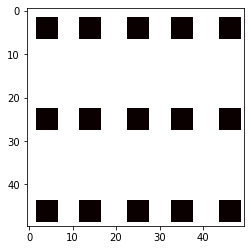

In [2]:
plt.imshow(isotropic_solver.grid[19], cmap='hot', interpolation='nearest')